# Convolutional neural networks with TensorFlow 2 for Supervised and Self-Supervised learning


In Part I of this notebook, you will learn to:

- use the Sequential class in TensorFlow to define a CNN model for classification.
- implement a supervised pipeline to train the CNN.

Next, in Part II of the notebook, you will learn to:
- use the tf.data.Dataset API to build an advanced input pipeline.
- use the Model class in TensorFlow to define a CNN-based autoencoder.
- Leverage the lower-dimensional representation of autoencoders to perform image retrieval.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/MLHD_labs/Lab_2'

/content/drive/MyDrive/MLHD_labs/Lab_2


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import skimage.transform
from cnn_utils import *
from dataset_utils import *
from sklearn.model_selection import train_test_split
import keras_utils
import random
import os

%matplotlib inline
np.random.seed(4)

# Part I

## 1 - The SIGN dataset

Run the next cell to load the "SIGNS" dataset you are going to use.

- `X_train` is the dataset used to train the model.
- `X_test` is the dataset to test the performance of the trained model.

Note that if you want to tune the hyperparameters of the network or if you want to apply stopping criterion based on metrics such as accuracy and loss, you need to use an additional dataset - called validation set -- to validate the model during the training process. In that case, the test and the validation sets must be disjoint sets otherwise the performance assessment would not be not "fair".

In [ ]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

y = 2


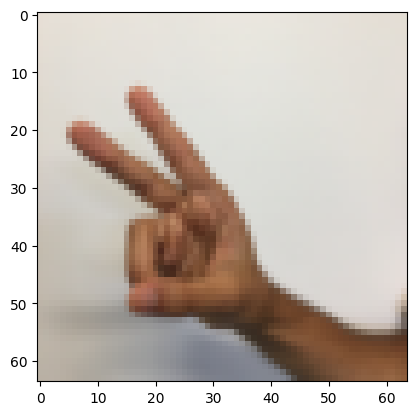

In [ ]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [ ]:
print("X train number of samples:", len(X_train_orig))
print("X test number of samples:", len(X_test_orig))
print("Images shape:", X_train_orig.shape[1:])

X train number of samples: 1080
X test number of samples: 120
Images shape: (64, 64, 3)


In [ ]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.

This laboratory includes two tasks:
- A supervised classification task.
- A self-supervised reconstruction task.

In the following cell, we convert the labels into one-hot vectors, as a pre-processing step for classification.

<img src="https://drive.google.com/uc?export=view&id=1V8kdqOc08-RtZ7uwxn5L1uoVgBtuSw_-" style="width:800px;">

***Note:*** this is the labels encoding we provide to TensorFlow in this notebook, but this is not the only way; integer labels, instead of their one-hot representation, can be used directly. Depending on the approach, the loss function should be modified accordingly.

```python
'sparse_categorical_crossentropy' # for direct label usage
'binary_crossentropy' or 'categorical_crossentropy' # for one hot encoding
```

Image pixels take values in the range \[0, 255\]. However, it is desirable to have absolute values in the range \[0, 1\] as input for neural network architectures, as that allows to reduce exploding or vanishing gradients problems. In the following cell we proceed using minmax normalization, which in this case corresponds to simply dividing the pixel values by 255 (with `normalize_img()`).

As an alternative, you can use the `StandardScaler()`. Note: to apply that function you need first to reshape the 4D matrices representing the data into 2D representation by flattening the 2nd, 3rd and 4th dimensions.

In [ ]:
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

## 2 - TensorFlow model

### 2.1 - Define the CNN model for classification

We use the TensorFlow built-in functions that carry out the convolution steps for you.

- **`tf.keras.layers.Conv2D(filters, kernel_size, strides, padding, activation)`:** You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

- **`tf.keras.layers.BatchNormalization(axis)`:** You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

- **`tf.keras.layers.MaxPool2D(pool_size, strides, padding)`:** You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

- **`tf.keras.layers.flatten()`**: You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)


- **`tf.keras.layers.Dense(units, activation)`:** You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)


**Exercise**:

Implement your model! There are two ways to do that in TensorFlow (see [here](https://www.tensorflow.org/api_docs/python/tf/keras/models)):
- The `Sequential` class, for simpler architectures.
- The `Model` class, for more complex topologies. Can do the same as Sequential and more.

Here, use **tf.keras.Sequential([layer1, layer2, ...])** to build the model.
```python
network_model = tf.keras.Sequential([tf.keras.layers.Conv2D(8, (3, 3), strides=(1,1), padding='same', activation=None), tf.keras.layers.BatchNormalization(axis=-1), ..., ...])
```

Full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)

You can start with the following structure and then try to experiment with different hyperparameter:

     - Conv2D: 4 channels at output, 3 by 3 filter size, stride 1, padding is "SAME"
     - BatchNormalization
     - ReLU activation
     - Max pool: 2 by 2 filter size and an 2 by 2 stride, padding is "SAME"
     - Conv2D: 8 channels at output, 3 by 3 filter size, stride 1, padding is "SAME"
     - BatchNormalization
     - ReLU activation
     - Max pool: Use a 2 by 2 filter size and a 2 by 2 stride, padding is "SAME"
     - Flatten the previous output
     - Dense layer: 16 neurons at output, relu activation function
     - Dense layer: 6 neurons at output without activation function
     
Do not call the softmax here. When implementing a neural network with TensorFlow you can choose whether to include the softmax directly inside the model definition or to combine that operation with the cost computation. In this notebook we use the latter approach.

In [ ]:
# NETWORK MODEL
tf.keras.utils.set_random_seed(21)
### START CODE HERE ### (1 line of code)
network_model = tf.keras.Sequential([tf.keras.layers.Conv2D(4, (3, 3), strides=(1,1), padding='same', activation=None),
                                   tf.keras.layers.BatchNormalization(axis=-1),
                                   tf.keras.layers.Activation('relu'),

                                   tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'),

                                   tf.keras.layers.Conv2D(8, (3, 3), strides=(1,1), padding='same', activation=None),
                                   tf.keras.layers.BatchNormalization(axis=-1),
                                   tf.keras.layers.Activation('relu'),

                                   tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'),

                                   tf.keras.layers.Flatten(),
                                   tf.keras.layers.Dense(16, activation='relu'),
                                   tf.keras.layers.Dense(6, activation=None)])
### END CODE HERE ###

Test your model: forward propagate random numbers.

In [ ]:
X = tf.random.normal((2, 64, 64, 3), dtype=tf.dtypes.float32)

outp = network_model(X, training=True)

print("outp = " + str(outp))

outp = tf.Tensor(
[[ 0.01124276  0.03689012 -0.08802629  0.2026251   0.25856423  0.16133794]
 [ 1.1456165   0.01899379 -1.0426909   0.05132267  1.5798377   0.5453207 ]], shape=(2, 6), dtype=float32)


**Expected Output with the suggested network**:

<table>
    <td>
    outp =
    </td>
    <td>
    [[ 0.01124276  0.03689012 -0.08802629  0.2026251   0.25856423  0.16133794]
    <br>
    [ 1.1456165   0.01899379 -1.0426909   0.05132267  1.5798377   0.5453207 ]]
    <br>
    </td>
</table>

**NOTE** If there are layers with different behavior during training versus inference (e.g., Dropout), you should write
```python
outp = network_model(X, training=True)
```

### 2.2 - Compute the cost

Implement below the function to compute the cost. For that, you need to combine the following two functions:

- **`tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)`:** computes the softmax entropy loss. This function computes the `softmax` activation function as well as the resulting loss. You can check the full documentation  [here.](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy)
Pay attention to the `from_logit` argument. The default value is `from_logits=False` which assumes that y_pred contains probabilities (i.e., the `softmax` activation was already applied to the output layer).
Instead, the computation of the loss starting from the logits (see [here](https://developers.google.com/machine-learning/glossary/#logits)) can be helpful with numerical stability. For that, we need to use `from_logits=True` and remember not to apply the softmax to the output of the network.

- **`tf.reduce_mean`:** computes the mean of elements across dimensions of a tensor. Use this to sum the losses over all the examples to get the overall cost. You can check the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)

**Exercise**: Compute the cost below using the function above.

In [ ]:
# FUNCTION: compute_cost

def compute_cost(outp, Y):
    """
    Computes the cost

    Arguments:
    outp -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as outp

    Returns:
    cost - Tensor of the cost function
    """

    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_pred= outp, y_true = Y, from_logits=True))
    ### END CODE HERE ###

    return cost

In [ ]:
X = tf.random.normal((2, 64, 64, 3), dtype=tf.dtypes.float32)
Y = tf.random.normal((2,6), dtype=tf.dtypes.float32)

outp = network_model(X, training=True)
cost = compute_cost(outp, Y)

print("cost = " + str(cost))

cost = tf.Tensor(2.145915, shape=(), dtype=float32)


**Expected Output with the suggested network**:

<table>
    <td>
    cost =
    </td>
    <td>
    2.145915
    </td>
</table>

### 2.3 - Train the network by implementing your own pipeline

Finally, you will merge the helper functions you implemented above to train the model on the SIGNS dataset.

We have implemented `random_mini_batches()` for you. This function returns a list of mini-batches to use during the training of your model.

**Exercise**: Complete the function below. Note that in the second part of the notebook you will use the TensorFlow built-in functions to do that.

The function below should:

- create an optimizer: use [tf.keras.optimizers.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- forward propagate the input
- compute the cost on the output
- compute the gradients: use
```python
tape.gradient(cost, network_model.trainable_variables)
```

Note: ``tf.GradientTape`` is used to record operations for the computation of the gradients. Reference [here](https://www.tensorflow.org/api_docs/python/tf/GradientTape)
- Apply the optimizer: use
```python
optimizer.apply_gradients(zip(gradients, network_model.trainable_variables))
```

Run a for loop for `num_epochs`, get the mini-batches, and then for each mini-batch optimize the function.

In [ ]:
# FUNCTION: model

def train_model(network_model, X_train, Y_train, X_test, Y_test, learning_rate = 0.005,
          num_epochs = 300, minibatch_size = 64, print_cost = True):
    """
    Train a ConvNet in TensorFlow

    Arguments:
    network_model -- the keras Sequential model to be trained
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- training set, of shape (None, n_y = 6)
    X_test -- test set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs

    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    validation_accuracy -- real number, testing accuracy on the validation set (X_val)
    """

    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []                                        # To keep track of the cost

    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    ### END CODE HERE ###

    # Do the training loop
    for epoch in range(num_epochs):

        minibatch_cost = 0.
        num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
        seed += 1
        minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

        for minibatch in minibatches:
            with tf.GradientTape() as tape:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch

                # Forward propagation
                ### START CODE HERE ### (1 line)
                outp = network_model(minibatch_X, training=True)
                ### END CODE HERE ###

                # Cost function
                ### START CODE HERE ### (1 line)
                cost = compute_cost(outp, minibatch_Y)
                ### END CODE HERE ###

            # Compute the gradient
            ### START CODE HERE ### (1 line)
            gradients = tape.gradient(cost, network_model.trainable_variables)
            ### END CODE HERE ###

            # Apply the optimizer
            ### START CODE HERE ### (1 line)
            optimizer.apply_gradients(zip(gradients, network_model.trainable_variables))
            ### END CODE HERE ###

            minibatch_cost += cost / num_minibatches

        # Print the cost every epoch
        if print_cost == True and epoch % 5 == 0:
            print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
        if print_cost == True and epoch % 1 == 0:
            costs.append(minibatch_cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # Calculate accuracy on the validation set
    train_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(network_model(X_train, training=False), 1), tf.argmax(Y_train, 1)), "float"))
    test_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(network_model(X_test, training=False), 1), tf.argmax(Y_test, 1)), "float"))

    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    return train_accuracy, test_accuracy, network_model

Now it's time to use the above function and train the convolutional neural network.

TensorFlow requires as input `tf.float32` values.
If you try the X_train dataset as it is, you will have the following warning:

`WARNING:tensorflow:Layer conv2d_2 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.`

With the following lines, we cast the data to the correct type. Note that it is not necessary to convert the numpy array to tensors to input them into the network. In fact, TensorFlow accepts numpy arrays as input and internally converts them into tensors.

In [ ]:
X_train_cast = X_train.astype(dtype=np.float32)
X_test_cast = X_test.astype(dtype=np.float32)

Cost after epoch 0: 1.927690
Cost after epoch 5: 1.047967
Cost after epoch 10: 0.717263
Cost after epoch 15: 0.493091
Cost after epoch 20: 0.338150
Cost after epoch 25: 0.213188
Cost after epoch 30: 0.125400
Cost after epoch 35: 0.166868
Cost after epoch 40: 0.100630
Cost after epoch 45: 0.047286


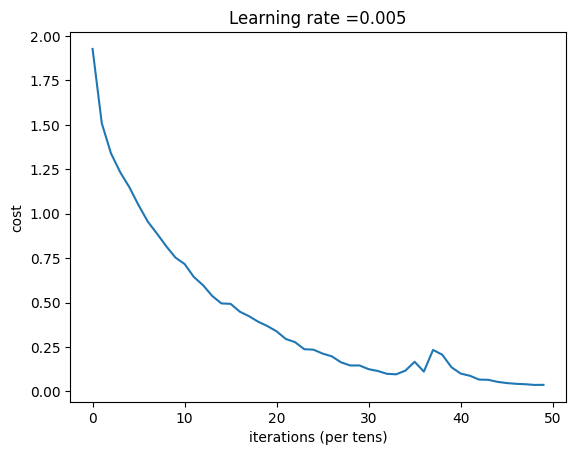

Train Accuracy: tf.Tensor(0.9953704, shape=(), dtype=float32)
Test Accuracy: tf.Tensor(0.8833333, shape=(), dtype=float32)


In [ ]:
_, _, network_model_trained = train_model(network_model, X_train_cast, Y_train, X_test_cast, Y_test, num_epochs=50)

# Part II

## 3 - Self-supervised learning using autoencoders

For the next task we will change the dataset.



### 3.1 - Malaria dataset

The Malaria dataset is a database of segmented cells from the thin blood smear slide images from the Malaria Screener research activity. The dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells.

You can find information about the dataset [here](https://lhncbc.nlm.nih.gov/LHC-research/LHC-projects/image-processing/malaria-screener.html)

Let's start by loading the names of the image files;  Next, we will load the images through the methods from the TensorFlow Dataset class. This is more efficient with respect to loading the entire dataset immediately.

In [ ]:
## Unzip the data from the shared Datasets folder into local "/content" folder.
## This will ensure fast data reading.
!unzip -q -o "/content/drive/MyDrive/MLHD_labs/Datasets/Lab_2/cell_images.zip" -d "/content"

In [ ]:
load_data_dir = '/content/cell_images'
labels = ['Parasitized', 'Uninfected']
tot_images = 5000  # number of images to consider for each diagnosis, at maximum 13780

X, Y = load_malaria_filenames(load_data_dir, labels, tot_images)

Loading filenames completed.


In the next cell of code, use the `train_test_split` from `sklearn.model_selection` to split the dataset into train and test sets (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)). Use `test_size=0.2`.

In [ ]:
# split the dataset into train and test groups using the package sklearn
### START CODE HERE ###
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
### END CODE HERE ###

In [ ]:
print("X number of samples:", len(X))
print("X train number of samples:", len(X_train))
print("X test number of samples:", len(X_test))
IMG_SHAPE = (100, 100, 3)

X number of samples: 10000
X train number of samples: 8000
X test number of samples: 2000


In [ ]:
def show_image(x):
    plt.imshow(x)

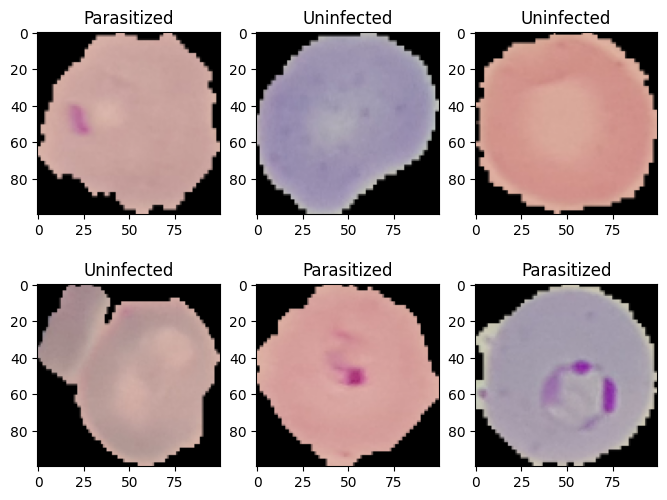

In [ ]:
plt.figure(figsize=(8, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    idx = random.randint(0, len(Y_train))
    show_image(normalize_img(load_malaria_image(X_train[idx])))
    plt.title(labels[Y_train[idx]])

### 3.2 - tf.data.Dataset API

The `tf.data.Dataset` API supports writing efficient input pipelines. We will see how to load the malaria images into a `tf.data.Dataset` object and how to apply transformations to the input data.
In that respect, if you use `tf.data.Dataset`, iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

The next function (i.e. `create_dataset()`) uses different methods from the API in order to carry out the input pipeline for the training. The function prepares the input for the self-supervised task the CNN-based autoencoder is going to carry out.
Remember that, in self-supervised learning, the target is represented by the input itself.

#### - **Create a Dataset object**
We use the method `from_tensor_slices` to instantiate a `tf.data.Dataset` object, which iteratively gets data from given tensors (documentation [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)). Specifically, we use as an argument a tuple composed of all the entries we want to include in the Dataset. In our case, we only need the `file_names` list (\['image1.png','image2.png'...\]) that indicates the data samples in `X` (`X_train` and `X_test` respectively).
Hint: use
```python
dataset = tf.data.Dataset.from_tensor_slices((file_names))
```
#### - **Map the functions to load and pre-process data**

The `map()` method (documentation [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)) allows applying functions to the elements of the dataset. In this case, we want to transform the filename string to a 32-bit tensor containing the actual images using the `load_malaria_image` function. Next, we execute again the `map()` method to normalize the images through the `normalize_img` function.

If the mapped function only uses built-in TensorFlow methods (which support tf tensors, e.g., *tf.cast()*, *tf.add()*, *tf.div()*...), you can directly pass it to the `.map(function)` method, as you did in Lab 2, section 3.2. This is the case for the second mapping operation, i.e., the one that applies the `normalize_image` function.

On the contrary, the `load_malaria_image` function uses external functions (e.g., the `imread` from opencv). In order to include arbitrary python functions inside the TensorFlow graph, we need to use `tf.numpy_function` (you can find more information [here](https://www.tensorflow.org/api_docs/python/tf/numpy_function)).
The downside of using custom Python functions is that they cannot leverage the TensorFlow-optimized logic (e.g., fast matrix multiplication on GPUs). Nevertheless, sometimes, especially when analyzing signals, we need (or want) this flexibility, accepting and considering the cost.

We used the `lambda` keyword to create the function in a lightweight manner. See [here](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) the documentation for the "lambda" keyword.

**NOTE**: By setting the *num_parallel_calls* parameter of the `.map()` function, you can easily parallelize your computation by spawning different processes. In this case, data are concurrently loaded and processed from files using all your available CPU cores!

#### - **Caching**

This is one of the most interesting features of the TensorFlow Dataset API. With a single line of code, you can implement an advanced caching system.

Let's consider a practical use case. In this example, the normalization step can be performed a single time on the entire dataset, since the result is always the same (*deterministic preprocessing*). Repeating these steps every time you load data is a waste of computational time and is highly inefficient. To avoid multiple executions of the same function we can leverage the *cache* method. In this way, the output of the dataset is only evaluated the first time, and all the subsequent calls will load data from the stored cache. The cache can store partial results both in a file or in memory (RAM), see the [documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) for more details.

**IMPORTANT NOTE**: The order of the dataset transformations is very important, especially when using a caching system. We will see below a practical example.

#### - **Shuffling**

This allows the data to be sampled in a different order at every epoch. Documentation [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).

**NOTE**: The `shuffle()` method requires a buffer to be filled **before** it can start to sample data (the buffer size is set by the *buffer_size* parameter). In this case, we are setting the shuffle buffer size equal to the dataset size. So, before starting to sample, the dataset must load all the data, and it can require some time in the beginning, especially if you are still creating the cache.

#### - **Repeat the dataset**

The `repeat()` method simply tells the dataset to start again when it runs out of samples. Documentation [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat). Without this step, each file would be loaded only one time during training, resulting in an error in the `fit()` method (as the last batch will be smaller than the others).

#### - **Batching**
The `batch()` method put together *batch_size* samples into a single batch of data, which will be the input of the network. Documentation [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch).

#### - **Prefetching**
While a process is training your network, this operation allows to load and process the subsequent chunk of data at the same time, greatly improving the idle time. Documentation [here](https://www.tensorflow.org/guide/data_performance#prefetching).

In [ ]:
def create_dataset(file_names, image_shape, batch_size, shuffle, cache_file=None):
    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names))
    print("Created dataset from tensor slices")

    # Map the load_malaria_image function
    py_func = lambda file_name: (tf.numpy_function(load_malaria_image, [file_name], tf.float32))
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())
    print("Mapped tf.numpy_function")

    # Fix the shape of the images in the dataset (needed after numpy_function operations)
    reshape_funct = lambda image: tf.reshape(image, image_shape)
    dataset = dataset.map(reshape_funct, num_parallel_calls=os.cpu_count())

    # Map the normalize_img function
    dataset = dataset.map(normalize_img, num_parallel_calls=os.cpu_count())
    print("Mapped normalize function")

    # Duplicate data for the autoencoder (input = output)
    py_funct = lambda img: (img, img)
    dataset = dataset.map(py_funct)
    print("Duplicated data for autoencoder (input=output)")

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)
        print("Cached dataset")

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(len(file_names))
        print("Shuffled dataset")

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()
    print("Repeated dataset")

    # Batch
    dataset = dataset.batch(batch_size=batch_size)
    print("Batched dataset")

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)
    print("Prefetched dataset")

    return dataset

### 3.3 - Dataset initialization
Now we can finally define our train and test dataset.

We also evaluate the number of steps (*train_steps* and *test_steps*) required to load and process the entire dataset (num. of samples / batch_size).

In [ ]:
batch_size = 32
train_dataset = create_dataset(X_train,
                               IMG_SHAPE,
                               batch_size=batch_size,
                               shuffle=True,
                               cache_file='train_cache')

test_dataset = create_dataset(X_test,
                               IMG_SHAPE,
                              batch_size=batch_size,
                              shuffle=False,
                              cache_file='val_cache')

train_steps = int(np.ceil(len(X_train) / batch_size))
test_steps = int(np.ceil(len(X_test) / batch_size))

Created dataset from tensor slices
Mapped tf.numpy_function
Mapped normalize function
Duplicated data for autoencoder (input=output)
Cached dataset
Shuffled dataset
Repeated dataset
Batched dataset
Prefetched dataset
Created dataset from tensor slices
Mapped tf.numpy_function
Mapped normalize function
Duplicated data for autoencoder (input=output)
Cached dataset
Repeated dataset
Batched dataset
Prefetched dataset


In [ ]:
print('Train dataset:', train_dataset)

print('Test dataset:', test_dataset)

Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None))>


As a part of the `tf.data.Dataset` API, we could have directly downloaded the dataset with the function:

```python
(train_dataset, test_dataset), dataset_info = tfds.load(name= 'malaria', with_info=True, as_supervised=True,
                                         split= 'train')
```

The Malaria dataset from TensorFlow has a single split that can be further divided into different sets later.

## 4 - Autoencoders (AEs)

As discussed during the lecture on autoencoders, PCA and a linear autoencoders minimize the same objective and find the same subspace as a result, with the difference that Linear AEs identify a set of basis vectors that aren't guaranteed to be orthogonal.

<img src="https://drive.google.com/uc?export=view&id=1XK15vXJth0_fwTc4KW1fxOHveC8aCbEQ" style="width:800px;">

<center><img src="https://drive.google.com/uc?export=view&id=1rUKSVGSnblKgcdgXr_dDeNRr1BtWOQMt" style="width:60%"></center>
<caption><center> Autoencoder structure</center></caption><br>

 However, AEs can also provide a non-linear low-dimensional representations of data thanks to non-linear activation functions and use different architectures.

### 4.1 - Going deeper: convolutional autoencoder

#### - Encoder

The **encoder** part is pretty standard and is obtained by stacking convolutional and pooling layers, and concluding with a dense layer to obtain a hidden representation of the desirable size (`code_size`).


Suggested architecture:

- use `activation='elu'` for all convolutional and dense layers

- repeat (conv, pool) 4 times with kernel size (3, 3), `padding='same'` and the following numbers of output channels: `32, 64, 128, 256`

Remember to flatten (`layers.Flatten()`) the output before adding the last dense layer to get your code.


#### - Decoder

To design the **decoder** we use the so-called "transposed convolutions".

The traditional convolutional layer takes a patch of an image and produces a number (patch -> number). In "transposed convolutions" we want to take a number and produce a patch of an image (number -> patch). We need this layer to "undo" the convolutions in the encoder.

<center><img src="https://drive.google.com/uc?export=view&id=1kby47kHGsZRu0cT6Qkai_VrYhFRwa_rP" style="width:55%"></center>
<caption><center> Transposed convolution </center></caption><br>

Suggested architecture:

- start with a dense layer to "undo" the last layer of the encoder ` layers.Dense(6*6*256)`

- reshape the output of the dense layer to "undo" `layers.Flatten()` in the encoder (hint: use `layers.Reshape((6, 6, 256))`)

- undo the (conv, pool) pairs in the encoder by stacking 4 `layers.Conv2DTranspose` layers with the following numbers of output channels: `128, 64, 32, 3`. Use a stride of 2 to produce a 4x4 output: in this way, you "undo" pooling as well. Documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose). Use `padding='same'` for all the layers except the second one (with 64 feature maps) where you need to use `padding='valid'` otherwise you will have dimensionality issues.

- for the last `layers.Conv2DTranspose` layer use `activation=None` as it is our final image.

#### - TensorFlow Model Class

For the Autoencoder training, we will use the `tf.keras.models.Model` class, which allows to define more complex networks and is more flexible than `tf.keras.Sequential`. Even though for this simple autoencoder "Sequential" API is more than sufficient, the purpose of the cell is to show how the "Model" class from the `Functional` API works.

Differently from ```Sequential()```, here you need to define an input layer.

```python
#Suppose you have defined a variable "input_shape", containing the shape of the input.
#The code will be something like the following, using as first layer an input layer.

input = tf.keras.Input(shape=(input_shape))

#Each layer is called as a function taking as argument the output of the previous layer, for example

x = tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'elu')(input)
x = tf.keras.layers.MaxPool2D((2, 2), padding = 'same')(x)

# ----- here the rest of the architecture -----

x = tf.keras.layers.Flatten()(x)

output = tf.keras.layers.Dense(64)(x)

#Once the input and the output variables are defined, the model can be created

model = tf.keras.Model(input, output, name = 'model_name')
```

***Remember:*** in the next cell, encoder and decoder should be defined as two different models with two different input layers.

You can find the reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model).

In [ ]:
# FUNCTION: define a convolutional decoder as described above

def build_deep_autoencoder(img_shape, code_size):
    """
    Arguments:
    img_shape_x -- size of the input layer
    code_size -- the size of the hidden representation of the input (code)

    Returns:
    encoder -- keras model for the encoder network
    decoder -- keras model for the decoder network
    """

    # encoder
    ### START CODE HERE ###
    input = tf.keras.Input(img_shape)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='elu', padding='same')(input)
    x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='elu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='elu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), activation='elu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Flatten()(x)
    code = tf.keras.layers.Dense(code_size)(x)

    encoder = tf.keras.Model(input, code, name = 'encoder')
    ### END CODE HERE ###

    # decoder
    ### START CODE HERE ###

    input = tf.keras.Input((code_size, ))

    x = tf.keras.layers.Dense(6 * 6 * 256, activation='elu')(input)
    x = tf.keras.layers.Reshape((6, 6, 256))(x)

    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, activation='elu', padding='same')(x)

    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation='elu', padding= 'valid')(x)

    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation='elu', padding='same')(x)

    reconstruction = tf.keras.layers.Conv2DTranspose(3, (3, 3), strides=2, activation= None, padding='same')(x)

    decoder = tf.keras.Model(input, reconstruction, name = 'decoder')
    ### END CODE HERE ###

    return encoder, decoder

In [ ]:
# check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output.shape[1:])
for code_size in [1, 8, 32, 128, 512]:
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:] == (code_size,), "encoder must output a code of required size"
    assert decoder.output_shape[1:] == IMG_SHAPE, "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights) >= 6, "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights) >= 6, "decoder must contain at least 3 layers"

    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)" % (
        layer.name, get_dim(layer))

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [ ]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, 32)
encoder.summary()
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 13, 13, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │       401,440 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789,856 (3.01 MB)

 Trainable params: 789,856 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 9216)           │       304,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_28             │ (None, 12, 12, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_29             │ (None, 25, 25, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_30             │ (None, 50, 50, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_31             │ (None, 100, 100, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 692,291 (2.64 MB)

 Trainable params: 692,291 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Build the autoencoder and train it

In [ ]:
# call the above function to create the encoder and decoder models, use code_size=32
### START CODE HERE ###
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
### END CODE HERE ###

In [ ]:
autoencoder_input = tf.keras.Input(IMG_SHAPE)
code = encoder(autoencoder_input)
reconstruction = decoder(code)
autoencoder = tf.keras.Model(autoencoder_input, reconstruction, name='autoencoder')

autoencoder.compile(optimizer='adam', loss='mse')

to choose a custom learning rate fo the optimizer, you can use:

```python
tf.keras.optimizers.Adam(learning_rate = 0.0005)
```

In [ ]:
# with the next lines, you save model's checkpoints to continue training in case of kernel death
model_filename = 'autoencoder_network.keras'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
# last_finished_epoch = 4  # replace with your latest finished epoch
# autoencoder = load_model(model_filename)
# encoder = autoencoder.layers[1]
# decoder = autoencoder.layers[2]

In [ ]:
history = autoencoder.fit(train_dataset, epochs=50,
                          steps_per_epoch=train_steps,
                          validation_data=test_dataset,
                          validation_steps=test_steps,
                          callbacks=[keras_utils.ModelSaveCallback(model_filename)],
                          verbose=1, initial_epoch=last_finished_epoch or 0)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0640Epoch 0 - Model saved in autoencoder_network.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 74ms/step - loss: 0.0639 - val_loss: 0.0188
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0169Epoch 1 - Model saved in autoencoder_network.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 0.0169 - val_loss: 0.0118
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0111Epoch 2 - Model saved in autoencoder_network.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0111 - val_loss: 0.0094
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0093Epoch 3 - Model saved in autoencoder_network.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 5/50
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0083Epoch 4 - Model saved in autoencoder_network.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 6/50
250/250 ━━━━━━━━

If you want, take a look at the `ModelSaveCallback` class. This class extends the `tf.keras.callbacks.Callback` one. Callbacks are utilities called at certain points during the training process. Documentation can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) and [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback). One interesting callback is the one to apply [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).
Here above we used a callback to save the model at the end of each epoch.

In [ ]:
# FUNCTION: draws original, encoded and decoded images

def visualize(img, encoder, decoder):
    """
    Arguments:
    img -- original image
    encoder -- trained encoder network
    decoder -- trained decoder network
    """

    code = encoder.predict(img[np.newaxis, :])[0]  # img[np.newaxis, :] is used to add an additional axis
                                                   # Remeber that the model takes as input a 4-dimensional array (?, height, width, channels) where the first dimension
                                                   # is the one related to the mini-batch size. Here our "mini-batch" is composed of a single image
    reco = decoder.predict(code[None])[0]  # img[None] is the same as img[np.newaxis, :]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

Now, let's visualize the reconstructed images

Convolutional autoencoder MSE: 0.00728261936455965
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


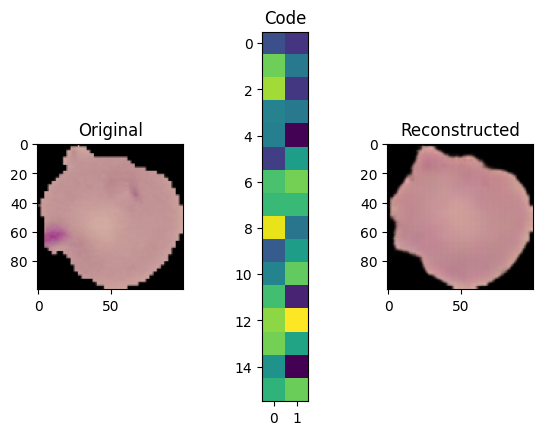

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


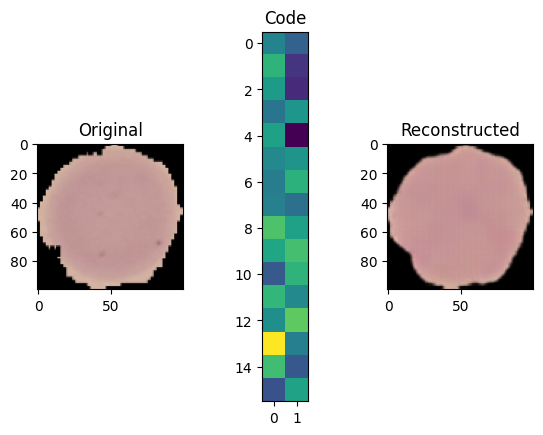

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


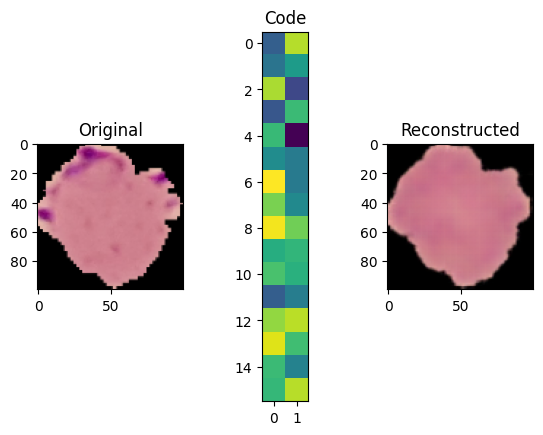

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


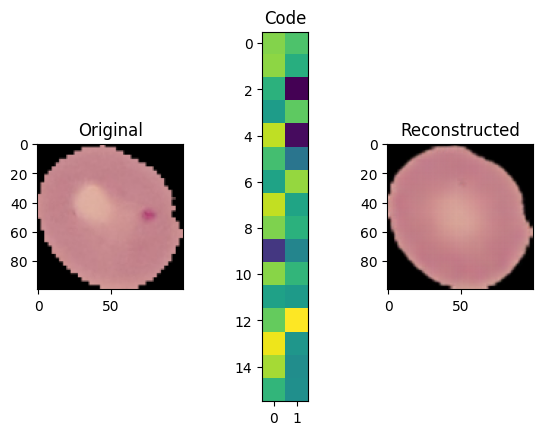

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


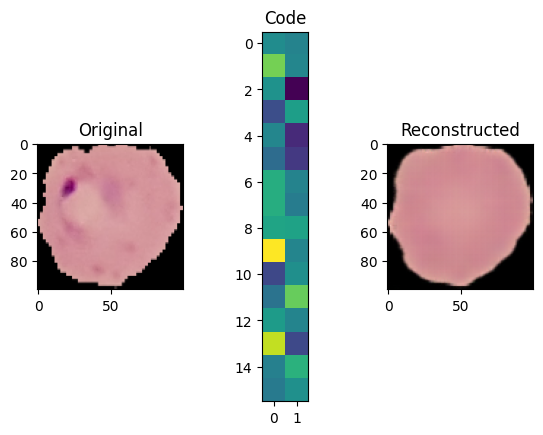

In [ ]:
reconstruction_mse = autoencoder.evaluate(test_dataset, steps=test_steps, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)

for i in range(5):
    idx = random.randint(0, len(X_test))
    img = normalize_img(load_malaria_image(X_test[idx]))
    plt.figure()
    visualize(img, encoder, decoder)
    plt.show()

#### Other useful TensorFlow instructions

Using TensorFlow classes built in methods, you can also save and load models or parameters and plot a graph representation of your model.

Run the following code.

In [ ]:
# Save and load models
encoder.save('encoder.keras')
encoder = tf.keras.models.load_model('encoder.keras')

# Save and load only the parameters
encoder.save_weights('encoder.weights.h5')
encoder.load_weights('encoder.weights.h5')

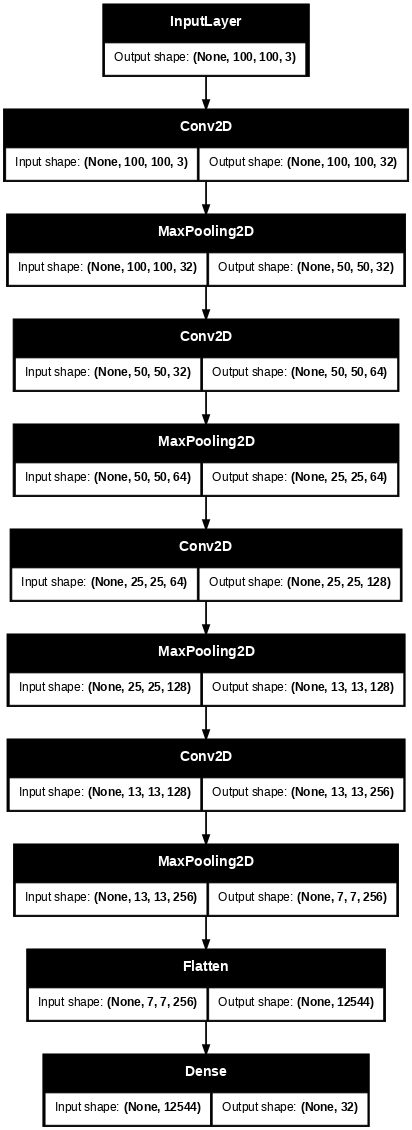

In [ ]:
dpi = 63
tf.keras.utils.plot_model(encoder, show_shapes=True, dpi = dpi, to_file = 'encoder.png')

from IPython.display import Image
Image(filename='encoder.png')

Note that all the methods used with objects from the class `tf.keras.models.Model` (such as the ones just shown) can be used with models defined through the class `tf.keras.Sequential` as well.

### 4.3 - Denoising Autoencoder

As seen during the course lectures, another one of the ways to "force" an autoencoder to learn a meaningful representation of data in the latent space (code), is to inject some random noise into the input.

<center><img src="https://drive.google.com/uc?export=view&id=1tly4Sb4K1ht87x8KxbEgvPWAp-rw61DU" style="width:60%"></center>
<caption><center> Denoising autoencoder </center></caption><br>

Training the network on such a task is done not mainly for the task itself (that can be useful too!), but rather to obtain a new representation, which can be useful in many ways. Later we will see one such application, using the code to perform image retrieval.

Another application can be features extraction: in case of scarcity of labeled data and lots of unlabeled ones, you could train an autoencoder in a self-supervised way and use the code as input for the supervised training of a classifier. In general, given enough labeled data, an end-to-end supervised training pipeline should lead to better performance.

There are different strategies to introduce noise: adding white Gaussian noise, occluding pixels using random black rectangles, etc.
Here, we use the first approach. Use `np.random.normal` (documentation [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)).

In [ ]:
# FUNCTION: add white Gaussian noise to the image

def apply_gaussian_noise(X, sigma=0.1):
    """
    Arguments:
    X -- image tensor of shape [batch, height, width, 3]
    sigma -- standard deviation for the gaussian noise

    Returns:
    X + noise --
    """
    ### START CODE HERE ###
    noise = np.random.normal(loc=0., scale=sigma, size=X.shape)
    ### END CODE HERE ###
    noise = noise.astype('float32')

    return X + noise

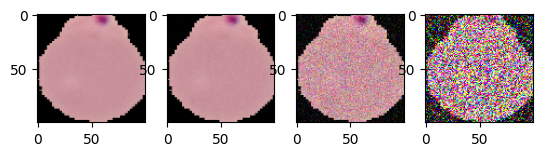

In [ ]:
# test different noise scales
plt.subplot(1,4,1)
show_image(normalize_img(load_malaria_image(X_train[0])))
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(load_malaria_image(X_train[0])/255., sigma=0.01))
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(load_malaria_image(X_train[0])/255., sigma=0.1))
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(load_malaria_image(X_train[0])/255., sigma=0.5))

In [ ]:
def create_noisy_dataset(file_names, image_shape, batch_size, shuffle, cache_file=None):
    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names))

    # Map the load_malaria_image function
    py_func = lambda file_name: (tf.numpy_function(load_malaria_image, [file_name], tf.float32))
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # Fix the shape of the images in the dataset (needed after numpy_function operations)
    reshape_funct = lambda image: tf.reshape(image, image_shape)
    dataset = dataset.map(reshape_funct, num_parallel_calls=os.cpu_count())

    # Map the normalize_img function
    dataset = dataset.map(normalize_img, num_parallel_calls=os.cpu_count())

    # Duplicate data for the autoencoder (input = output)
    py_funct = lambda img: (img, img)
    dataset = dataset.map(py_funct)

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Map the apply_gaussian_noise function to add Gaussian noise to the input image
    py_funct = lambda img_in, img_out: (tf.numpy_function(apply_gaussian_noise, [img_in], tf.float32), img_out)
    dataset = dataset.map(py_funct)

    # Fix the shape of the images in the dataset (needed after numpy_function operations)
    reshape_funct = lambda img_in, img_out: (tf.reshape(img_in, image_shape), img_out)
    dataset = dataset.map(reshape_funct, num_parallel_calls=os.cpu_count())

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

In [ ]:
batch_size = 32
train_dataset = create_noisy_dataset(X_train,
                               IMG_SHAPE,
                               batch_size=batch_size,
                               shuffle=True,
                               cache_file='train_cache')

test_dataset = create_noisy_dataset(X_test,
                              IMG_SHAPE,
                              batch_size=batch_size,
                              shuffle=False,
                              cache_file='val_cache')

train_steps = int(np.ceil(len(X_train) / batch_size))
test_steps = int(np.ceil(len(X_test) / batch_size))

In [ ]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

inp = layers.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

denoising_autoencoder = tf.keras.Model(inp, reconstruction)
denoising_autoencoder.compile('adamax', 'mse')

model_filename = 'denoising_autoencoder_network.keras'
last_finished_epoch = None

# NOTE: with the create_noisy_dataset function, the noise is added independently at each epoch so at each
# epoch the images are corrupted differently --> good to learn better
history = denoising_autoencoder.fit(train_dataset, epochs=50,
                          steps_per_epoch=train_steps,
                          validation_data=test_dataset,
                          validation_steps=test_steps,
                          callbacks=[keras_utils.ModelSaveCallback(model_filename)],
                          verbose=1, initial_epoch=last_finished_epoch or 0)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0725Epoch 0 - Model saved in denoising_autoencoder_network.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - loss: 0.0723 - val_loss: 0.0209
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0202Epoch 1 - Model saved in denoising_autoencoder_network.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - loss: 0.0202 - val_loss: 0.0174
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0170Epoch 2 - Model saved in denoising_autoencoder_network.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - loss: 0.0170 - val_loss: 0.0149
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0141Epoch 3 - Model saved in denoising_autoencoder_network.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - loss: 0.0141 - val_loss: 0.0120
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0118Epoch 4 - Model saved in denoising_autoencoder_network.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - loss: 

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0068
Denoising MSE: 0.006853966042399406
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


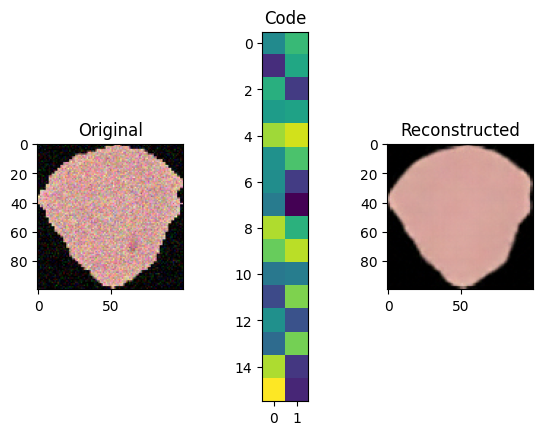

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


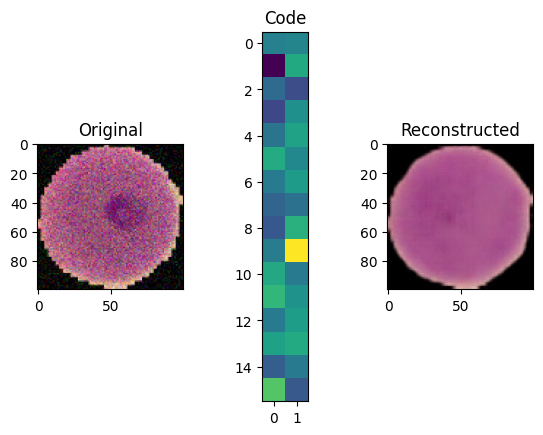

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


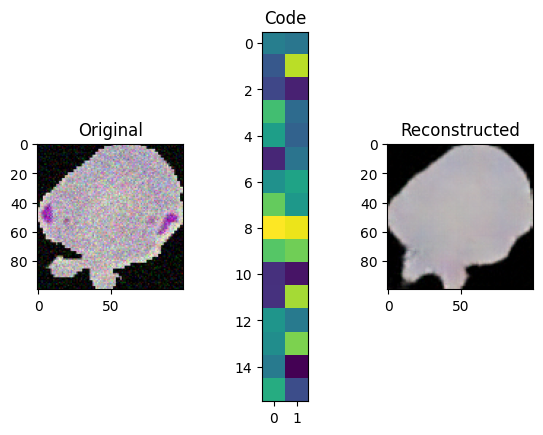

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


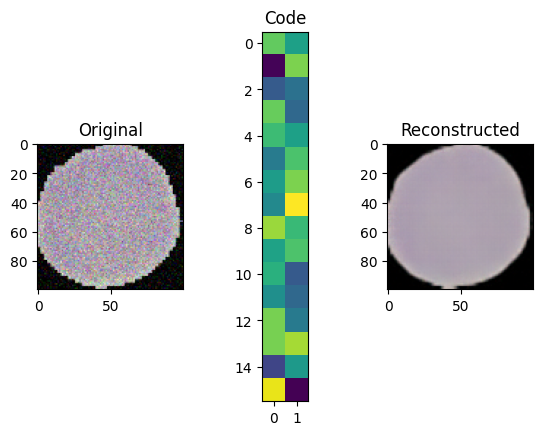

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


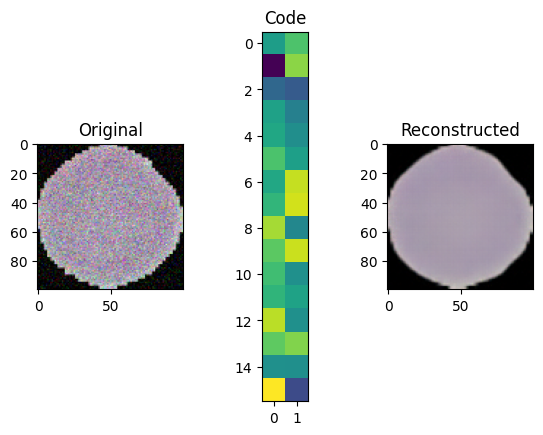

In [ ]:
denoising_mse = denoising_autoencoder.evaluate(test_dataset, steps=test_steps)
print("Denoising MSE:", denoising_mse)

for i in range(5):
    idx = random.randint(0, len(X_test))
    img = apply_gaussian_noise(normalize_img(load_malaria_image(X_test[idx])))
    plt.figure()
    visualize(img, encoder, decoder)
    plt.show()

## 5 - Image retrieval using autoencoders

We can now use our encoder, feeding it with images from the malaria dataset and performing some similarity search in the latent space.

Here below you will try to use k-nearest neighbors algorith, to perform the search. First of all, let's compute the code for all the images in the dataset.

In [ ]:
# encode the images in the training set (hint: use the method predict() applied to the encoder network and specify `steps=train_steps`)
### START CODE HERE ###
codes = encoder.predict(train_dataset, steps=train_steps)
### END CODE HERE ###

codes = codes[:len(X_train)]  # to remove final duplicates used to complete the last batch
assert len(codes) == len(X_train)

250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step


Now, we use the unsupervised learner `sklearn.neighbors.NearestNeighbors` (documentation [here](https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-neighbors) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) to group images in the dataset based on their similarities We use the euclidean distance as a measure for the similarities.

After setting up the learner, call the `fit()` method to fit the model using the codes generated above (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.fit)).

In [ ]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(metric="euclidean")

# fit the model using the codes

### START CODE HERE ###
nbrs.fit(codes)
### END CODE HERE ###

NearestNeighbors(metric='euclidean')

In the next function the `n_neighbors` neighbors of the image passed as the argument are returned. To do that:

- first, the hidden code of the received image is computed

- then, the method `kneighbors` is called on the `nbrs` object created above. This method returns the indices of the neighbors of the image in the dataset and distances to them (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors)).

In [ ]:
# FUNCTION: return the `n_neighbors` neighbors of `image` in the dataset

def get_similar(image, n_neighbors=5):

    code = encoder.predict(image[None])
    (distances,),(idx,) = nbrs.kneighbors(code, n_neighbors=n_neighbors)

    return distances, idx

In [ ]:
# FUNCTION: visualize the `n_neighbors` neighbors of `image` in the dataset

def show_similar(image, X_train):

    distances, neighbors_idxs = get_similar(image, n_neighbors=3)

    plt.figure(figsize=[8,7])
    plt.subplot(1, 4, 1)
    show_image(image)
    plt.title("Original image")

    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(normalize_img(load_malaria_image(X_train[neighbors_idxs[i]])))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

Apply the functions to visualize some examples.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


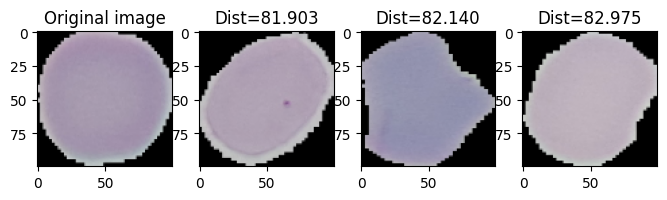

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


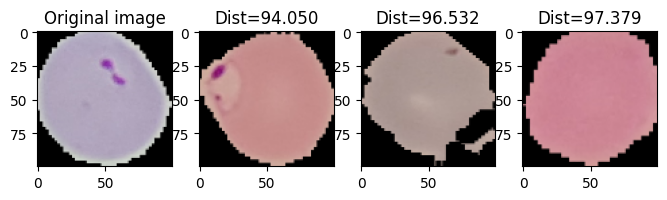

In [ ]:
show_similar(normalize_img(load_malaria_image(X_test[random.randint(0, len(X_test))])), X_train)
show_similar(normalize_img(load_malaria_image(X_test[random.randint(0, len(X_test))])), X_train)